## Train and stores embeddings

this colab loads a the code from git, trains GMM/GVAE model and stores the embeddings for further analysis



In [ ]:
#@title Set up and imports
from google.colab import drive 
import os 

import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras.engine import node
from tensorflow.python.keras.engine.node import Node 
import tensorflow_probability as tfp
tfd = tfp.distributions
WORKING_PATH = './drive/MyDrive/GGMbetaFactorVAE' 




In [1]:
#@title Set up and imports
from google.colab import drive 
import os 

import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras.engine import node
from tensorflow.python.keras.engine.node import Node 
import tensorflow_probability as tfp
tfd = tfp.distributions
WORKING_PATH = './drive/MyDrive/GGMbetaFactorVAE' 

if 'first_run' not in locals():
  drive.mount('/content/drive/')
  os.chdir(WORKING_PATH)

  !rm -rf GVAE
  !git clone -b remote_run https://github.com/EdoardoPona/GVAE.git

  first_run = False


os.chdir('./GVAE/src')
# for some reason imports in the repo are executed form this directory, 
# need to fix this 


#git imports
from models import GM_VGAE, VGAE
import utils

Mounted at /content/drive/
Cloning into 'GVAE'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 76 (delta 44), reused 51 (delta 22), pack-reused 0
Unpacking objects: 100% (76/76), done.


ModuleNotFoundError: ignored

In [ ]:
## Loads data

network_path = 'data/diseasome/disease_network_adj.npy'
labels_path = 'data/diseasome/disease_network_types.npy'
output_path = 'data/saved/diseasome/model/'

data_params = dict(network_path = network_path,
                   labels_path = labels_path,
                   use_features=False,
                   auxiliary_prediction_task=True,
                   epochs=100)

adj, target, dataset = utils.load_and_build_dataset(data_params)

DONE: train_edges
DONE: test_edges_false
DONE: val_edges_false
True
True
True
True
True


In [ ]:
## Defines basic training step


def train_step(adj_normalized, features, adj_label, norm, pos_weight, experiment_params, class_targets=None):   
    model_type = experiment_params['model']
    assert model_type in ['VGAE', 'GM_VGAE']
    assert ((model_type=='VGAE' and class_targets is None) or (model_type=='GM_VGAE'))

    with tf.GradientTape() as tape:
        beta = 1
        adj_label = tf.reshape(adj_label, [-1])

        Q, Q_log_std, reconstructed = model(adj_normalized, features)
        reconstruction_loss = norm * tf.math.reduce_mean(
            tf.nn.weighted_cross_entropy_with_logits(labels=adj_label, logits=reconstructed, pos_weight=pos_weight)
        ) 

        if model_type == 'VGAE':
            kl = (0.5 / adj_label.shape[0]) * tf.math.reduce_mean(
                tf.math.reduce_sum(1 + 2 * Q_log_std - tf.math.square(Q.loc) - tf.math.square(Q.scale), axis=1)
            ) 
            # NOTE: why are these two different? they should give the same performance
            kl = tf.reduce_mean(tfd.kl_divergence(Q, model.prior))
            classification_loss = 0
        else:
            kl = tf.reduce_mean(mc_kl_divergence(Q, model.prior))
            # kl = tf.reduce_mean(kl_divergence_upper_bound(Q, model.prior))
            if experiment_params['auxiliary_prediction_task']:
                classification_loss = tf.reduce_mean(
                    tf.nn.softmax_cross_entropy_with_logits(logits=model.cy_logits, labels=class_targets)
                )
            else: 
                classification_loss = 0
        
        vae_loss = reconstruction_loss + beta*kl + classification_loss

    gradients = tape.gradient(vae_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # metrics
    RECONSTRUCTION.append(reconstruction_loss.numpy())
    KL_LOSSES.append(kl.numpy())
    LOSSES.append(vae_loss.numpy())
    CLASSIFICATION_LOSSES.append(classification_loss.numpy())

In [ ]:
## Initializes experiment 

experiment_params = dict(
    learning_rate=1e-3,
    epochs=500,
    hidden=32,
    latent_size=16,
    dropout=0.2 ,
    model='VGAE',
    use_features=True,      # whether to use features (1) or not (0)
    auxiliary_prediction_task=True,
    save_path=output_path )
    
optimizer = tf.keras.optimizers.Adam(lr=experiment_params['learning_rate'])
RECONSTRUCTION = []
KL_LOSSES = []
LOSSES = []
CLASSIFICATION_LOSSES = []

pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

node_num = adj.shape[0]
class_num = target.shape[1]
if experiment_params['model'] == 'VGAE':
    model = VGAE(node_num=node_num, 
                  hidden=experiment_params['hidden'], 
                  latent_size=experiment_params['latent_size'],
                  dropout=experiment_params['dropout'])
elif experiment_params['model'] == 'GM_VGAE':
    model = GM_VGAE(node_num=node_num, 
                    class_num=class_num, 
                    hidden=experiment_params['hidden'],
                    dropout=experiment_params['dropout'])


In [ ]:
## Training loop

e = 0
for adj_norm, features, label in dataset:
  train_step(adj_norm, features, label, norm, pos_weight, experiment_params, class_targets=target)
  if e % 100 == 0:
    print('total: {:.2f}, rec: {:.2f}, classification: {:.2f}, kl_loss: {:.2f}'.format(
        LOSSES[-1], RECONSTRUCTION[-1], CLASSIFICATION_LOSSES[-1], KL_LOSSES[-1]))
  e +=1

total: 4.82, rec: 1.73, classification: 3.09, kl_loss: -0.00


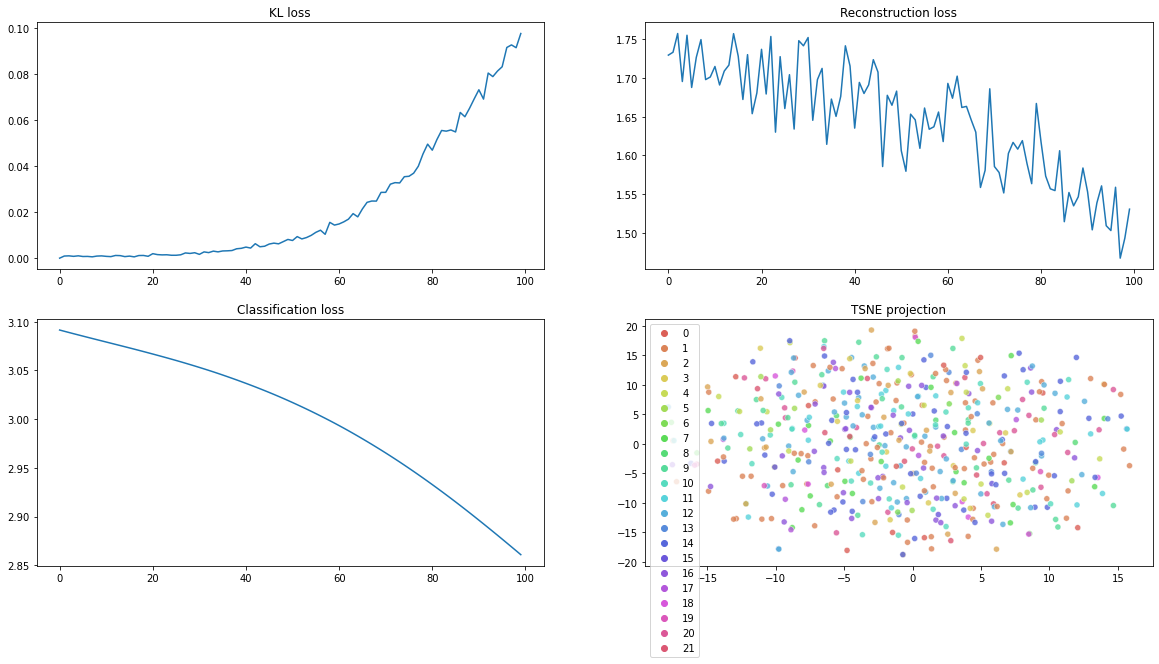

In [ ]:
#@title Diagnosis plots - losses seem to be working as inteded but TSNE still doesn't not show expected class clustering
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.manifold import TSNE

Q = model.Q
z = tf.squeeze(Q.sample(1))
z_proj = TSNE(n_components=2).fit_transform(z)

fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.flatten()

axs[0].plot(KL_LOSSES)
axs[0].set_title('KL loss')

axs[1].plot(RECONSTRUCTION)
axs[1].set_title('Reconstruction loss')

axs[2].plot(CLASSIFICATION_LOSSES)
axs[2].set_title('Classification loss')


if 'z_proj' in locals():
  sns.scatterplot(
      x=z_proj[:, 0], y=z_proj[:, 1],
      palette=sns.color_palette("hls", target.shape[1]),
      hue=np.where(target==1)[1],
      legend='full', 
      alpha=0.8,
      ax=axs[3]
  )

  axs[3].set_title('TSNE projection')

In [ ]:
# saves model
model.save_weights(experiment_params['save_path'])